**Motivation**<br>
play with the vertical edge filter from first principles<br>
example filters available at https://docs.gimp.org/en/plug-in-convmatrix.html <br>
helper functions come from Andrew Ng Deep Learning specialization courses on Coursera

In [1]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant')
    
    return X_pad

In [3]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """

    s = np.multiply(a_slice_prev, W)
    Z = np.sum(s)
    Z = Z + b.item()

    return Z

In [4]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above
    n_H = int((n_H_prev - f + 2*pad)/stride + 1)
    n_W = int((n_W_prev - f + 2*pad)/stride + 1)
    
    # Initialize the output volume Z with zeros.
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]                               # Select ith training example's padded activation
        for h in range(n_H):                           # loop over vertical axis of the output volume
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h*stride
                    vert_end = h*stride + f
                    horiz_start = w*stride
                    horiz_end = w*stride + f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell).
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. 
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                                        
    
    # Making sure the output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

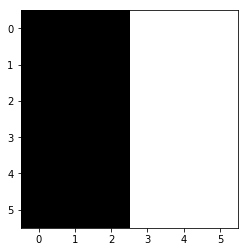

In [5]:
# y is a 6 x 6 black and white image
y = np.array([[10,10,10,0,0,0],[10,10,10,0,0,0],[10,10,10,0,0,0],[10,10,10,0,0,0],[10,10,10,0,0,0],[10,10,10,0,0,0]])
plt.imshow(y/255, cmap='Greys')

In [6]:
# c is a filter
c = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
W = c.reshape(3,3,1,1)

# ignore bias for simplicity
b = np.zeros(1).reshape(1,1,1,1)

# use the simplest stride and padding
hparameters = {'stride':1, 'pad':0}

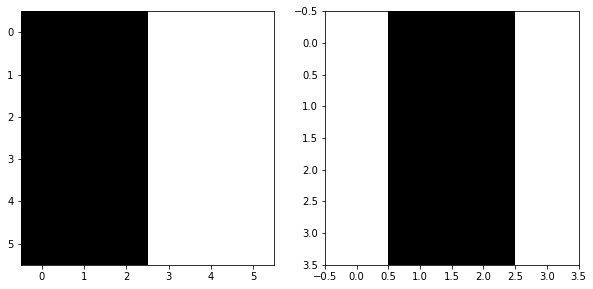

In [7]:
x = y.reshape(1, y.shape[0], y.shape[1], 1)
Z, _ = conv_forward((x/255), W, b, hparameters)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(y/255, cmap='Greys')
plt.subplot(122)
plt.imshow(Z[0].reshape(Z[0].shape[0],Z[0].shape[0]), cmap='Greys')
plt.show()
plt.close()

instead of 6 x 6, do 64 x 64, see if it makes the edge on the right image thinner

In [8]:
# now y is a 64 x 64 black and white image
a = np.repeat([10,0],32,axis=0).reshape(1,64)
y = np.repeat(a,64, axis=0)

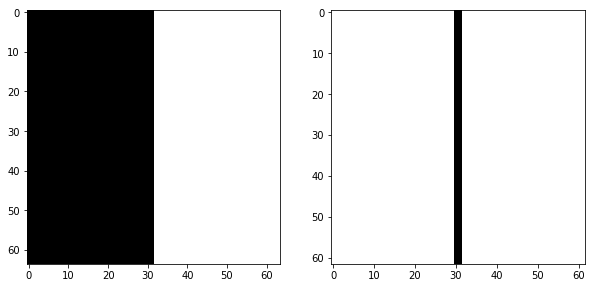

In [9]:
# this is it!
# apply 3 x 3 edge detector filter to left image, stride 1 and no padding, we obtain right image
x = y.reshape(1, y.shape[0], y.shape[1], 1)
Z, _ = conv_forward((x/255), W, b, hparameters)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(y/255, cmap='Greys')
plt.subplot(122)
plt.imshow(Z[0].reshape(Z[0].shape[0],Z[0].shape[0]), cmap='Greys')
plt.show()
plt.close()

**Discussion**<br>
In the above images, left is the raw 64 x 64 image, designed deliberately with an edge in the middle to be detected. We then convolve it with a 3 x 3 filter and obtain the 62 x 62 image on the right (stride = 1, pad = 0). Notice how the right image specializes by just capturing the vertical edge and ignore everything else. In a more realistic setting, the left image will contain more patterns, and we need multiple filters to detect them, one filter per pattern. Behind the right image is a set of neurons in the convolution layer, with the ones corresponding to the middle edge being turned on. It's really a division of labor between these filters, I detect vertical edges, you detect horizontal edges, he detects some other pattern, and so on. And then we move on to the next layer, and repeat this process at a more abstract level. What's remarkable is that the division of labor between filters is completely spontaneous. Once the architecture of the network (number of filters, number of conv layers, etc) is fixed, the filters are learned from data.